# **ETPoF** Homework 2
Annemarie Linnenbank & Tommie Verouden

*8 March 2024*

## Part a: Optical Calibration (13 points)

### 1a1) **Image resolution**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.spatial as spatial

%matplotlib widget

https://docs.opencv.org/4.6.0/d9/d0c/group__calib3d.html#ga7f02cd21c8352142890190227628fa80

NOT SURE IF COEN ALLOWS FINDCIRCLESGRID

In [2]:
# Define calibration parameters
grid_size_x = 25
grid_size_y = 25
calibration_distance = 5  # mm

def find_centers(img, grid_size_x, grid_size_y, plot=False):
    # Find circle grid using opencv
    grid_found, centers = cv2.findCirclesGrid(
        img, (grid_size_x, grid_size_y), flags=cv2.CALIB_CB_SYMMETRIC_GRID)
    
    # If the grid was not found, print an error message
    if not grid_found:
        print("Grid not found")
        return

    if plot:
        # Plot the image and the found circle centres
        fig, ax = plt.subplots()
        ax.imshow(img, cmap='gray')
        ax.scatter(centers[:, 0, 0], centers[:, 0, 1], c='g', s=10, marker=".")
        ax.set_title('Detected circle centers')
        ax.set_xlabel('x [px]')
        ax.set_ylabel('y [px]')

        # Make an inset of the top left corner of the image
        ax.add_patch(plt.Rectangle((5, 5), 120, 120,
                    fill=False, color='b', linewidth=2))
        axins = ax.inset_axes([0.15, 0.35, 0.5, 0.5], xlim=(
            5, 120), ylim=(120, 5), xticks=[], yticks=[])
        axins.imshow(img, cmap='gray', origin="upper")
        axins.scatter(centers[:, 0, 0], centers[:, 0, 1], c="g", s=100, marker="+")
        axins.spines[:].set_color('blue')
        axins.spines[:].set_linewidth(2)
        plt.show()
    
    return centers

# Import image Clean.png
img_clean = cv2.imread('Images/Calibration_a/Clean.png',0)

# Find the centers of the circles
centers = find_centers(img_clean, grid_size_x, grid_size_y, plot=False)

$$d = \sqrt{x^2+y^2}$$

In [10]:
circles = cv2.HoughCircles(img_clean, cv2.HOUGH_GRADIENT, 1, 1000,
                           param1=140, param2=1,
                           minRadius=3, maxRadius=14)

# # loop over the (x, y) coordinates and radius of the circles
# for (x, y, r) in circles_coords:
#     # draw the circle in the output image, then draw a rectangle
#     # corresponding to the center of the circle
#     cv2.circle(img_clean_out, (x, y), r, (255, 0, 0), 4)
#     # cv2.rectangle(img_clean_out, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)


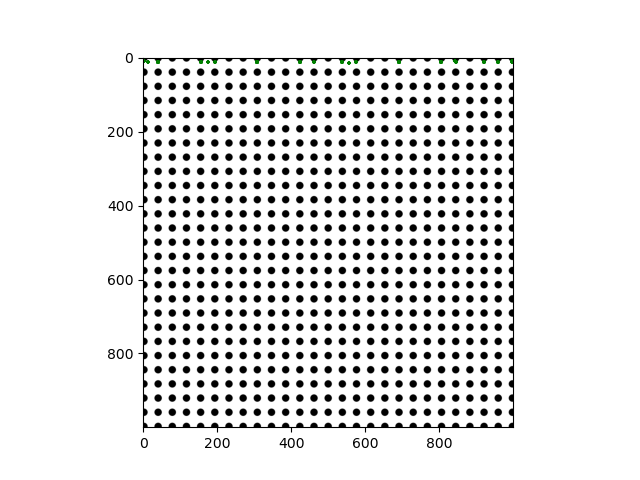

In [9]:
plt.imshow(img_clean, cmap='gray')
plt.scatter(circles[0, :, 1], circles[0, :, 2], c='g', s=10, marker="+")
plt.show()

In [14]:
circles[0,:,:]

array([[ 40.5, 308.5,  10.2],
       [ 40.5, 691.5,  10.2],
       [193.5, 308.5,  10.2],
       ...,
       [997.5, 538.5,  10.1],
       [997.5, 844.5,  10.1],
       [997.5, 921.5,  10.1]], dtype=float32)

Implemented using off-the-shelf matrix operations in Numpy, so should be fairly quick to run.

In [4]:
def distances_from_grid(centers, calibration_distance, grid_size_x, grid_size_y):
    """
    Calculate the distance between all points in the grid

    PARAMETERS:
        centers (np.array): The centers of the circles in the grid (n, 1, 2).
    """
    # Reshape the array to remove extra dimension
    centers = centers.reshape(-1, 2)

    # Calculate the Euclidian distance between all points
    distances_px = spatial.distance.cdist(centers, centers, 'euclidean')

    # Get the indices of each point in the grid
    centers_idx = np.indices([grid_size_x, grid_size_y])

    # Make sure the points are defined in the same order as the distance matrix
    centers_idx = np.reshape(centers_idx.T, (grid_size_x * grid_size_y, 2))

    # Now calculate, again, the Euclidian distance, but this time in the index space
    distances_idx = spatial.distance.cdist(
        centers_idx, centers_idx, 'euclidean')

    # The real distance is now given by the distance between
    #  two neighbouring points in real space times the distance in index space
    distances_real = calibration_distance * distances_idx

    return distances_px, distances_real

In [5]:
distances_px, distances_real = distances_from_grid(centers, calibration_distance, grid_size_x, grid_size_y)

# Because the distance between a point and itself is 0, we ignore the division by zero warning
with np.errstate(divide='ignore', invalid='ignore'):
    # and calculate the resolution for each distance between any two circles
    resolutions = distances_real / distances_px

How to weigh the distances?
Since the error goes down with 1/distance, we can just weigh the points by distance.


In [6]:
def weighted_avg_and_std(values, weights):
    """
    Calculate the weighted average and standard deviation of a set of values.

    PARAMETERS:
        values (array-like): The values for which to calculate the weighted average and standard deviation.
        weights (array-like): The weights corresponding to each value.

    RETURNS:
        tuple: A tuple containing the weighted average and standard deviation.
    """

    # Calculate the weighted average
    average = np.average(values, weights=weights)

    # Calculate the weighted variance
    variance = np.average((values-average)**2, weights=weights)

    # Output the average and standard deviation
    return (average, np.sqrt(variance))

# Mask all values on the diagonal
mask = np.eye(grid_size_x * grid_size_y, dtype=bool).__invert__()

# Calculate the weighted average and standard deviation of the resolution
resolution_av, resolution_std = weighted_avg_and_std(
    resolutions[mask], distances_real[mask])

print(f"The average resolution is {resolution_av:.5f} mm/px with a standard deviation of {resolution_std:.5f} mm/px.")

The average resolution is 0.13055 mm/px with a standard deviation of 0.00001 mm/px.


Try to estimate error in blob detector centers

### 1a2) **Noise, rotation & lens vignetting**

8-bit image, so intensity is in [0, 255]

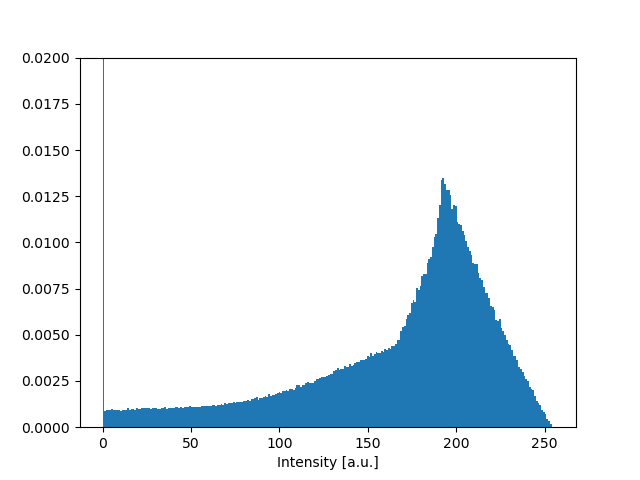

In [7]:
# Import the distorted image
img_dist_edit = cv2.imread('Images/Calibration_a/Distorted.png', 0)

# Make an intensity histogram
fig, ax = plt.subplots()
ax.hist(img_dist_edit.flatten(), bins=256, range=[0, 255], density=True)
plt.ylim([0, 0.02])

plt.xlabel('Intensity [a.u.]')

plt.show()


Peak for zero intensity goes up to 0.86.

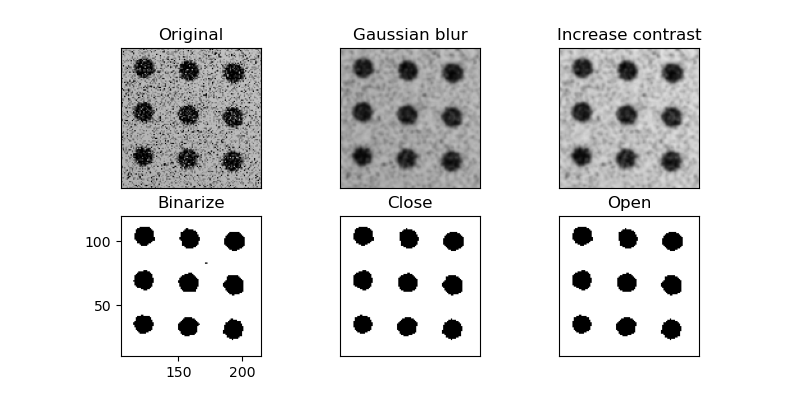

In [8]:
# Parameters
blur_kernel = 5
contrast = 1.2
brightness = 0
binary_kernel = 31
binary_constant = 51
morph_kernel = 5

# Import the distorted image and make a copy
img_dist = cv2.imread('Images/Calibration_a/Distorted.png', 0)
img_dist_edit = img_dist.copy()

# Set up a plot, show original image (1)
fig, ax = plt.subplots(2, 3, figsize=(8, 4))
ax[0, 0].imshow(img_dist_edit, cmap='gray')

# Apply a Gaussian blur (2)
img_dist_edit = cv2.GaussianBlur(img_dist, (blur_kernel, blur_kernel), 0)
ax[0, 1].imshow(img_dist_edit, cmap='gray')

# Increase the contrast (3)
img_dist_edit = cv2.addWeighted(
    img_dist_edit, contrast, img_dist_edit, brightness, 0)
ax[0, 2].imshow(img_dist_edit, cmap='gray')

# Binarize the image with adaptive threshold (4)
img_dist_edit = cv2.adaptiveThreshold(
    img_dist_edit, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, binary_kernel, binary_constant)
# _, img_dist_edit = cv2.threshold(img_dist_edit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ax[1, 0].imshow(img_dist_edit, cmap='gray')

# Close the image with a circular kernel to remove small components (5)
kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
img_dist_edit = cv2.dilate(img_dist_edit, kernel)
img_dist_edit = cv2.erode(img_dist_edit, kernel)
ax[1, 1].imshow(img_dist_edit, cmap='gray')

# Open the image with the same kernel to fill small holes (6)
img_dist_edit = cv2.erode(img_dist_edit, kernel)
img_dist_edit = cv2.dilate(img_dist_edit, kernel)
ax[1, 2].imshow(img_dist_edit, cmap='gray')

# Finish the plot
subplot_names = ['Original', 'Gaussian blur',
                 'Increase contrast', 'Binarize', 'Close', 'Open']

for ii, a in enumerate(ax.flatten()):
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlim([105, 215])
    a.set_ylim([10, 120])
    a.set_title(subplot_names[ii])

ax[1,0].set_xticks([150, 200])
ax[1,0].set_yticks([50, 100])
plt.show()

Note that the final step has become a bit redundant after we tweaked the binarisation values, but we left it in for completeness sake.

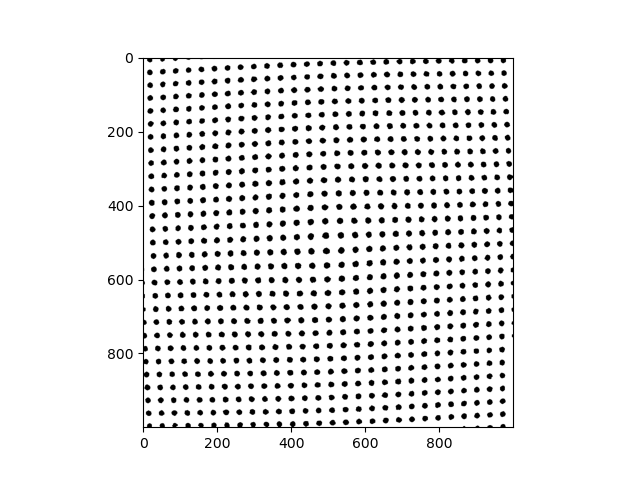

In [9]:
fig, ax = plt.subplots()
ax.imshow(img_dist_edit, cmap='gray')

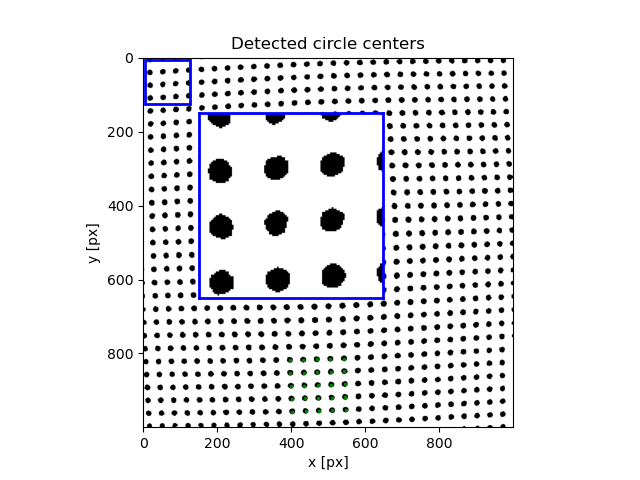

In [18]:
# Define calibration parameters
calibration_distance = 2  # mm
grid_size_x = grid_size_y = 5
# grid_size_y = 23

# Find circle grid using opencv
centers = find_centers(img_dist_edit, grid_size_x, grid_size_y, plot=True)

# distances_from_grid(centers, calibration_distance, grid_size_x, grid_size_y)

### 1a3) **Radially-varying resolution**

In [72]:
resolution[:, :].reshape(9, 3, 3)

ValueError: cannot reshape array of size 390625 into shape (9,3,3)